In [1]:
import sys
import warnings
import matplotlib 

sys.path.append('..')
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import timedelta
from scipy.stats import beta

sns.set_style("whitegrid")

plt.rc("text", usetex=True)
plt.rc("font", family="serif")
matplotlib.rcParams["text.latex.preamble"] = [r"\usepackage{amsmath}"]

## Data

The data consits of COVID-19 positive test counts (`Daily lab-confirmed cases`) by Lower tier local authority (LTLA) as reported on a given date (`Report date`) for all preceding test dates (`Specimen date`).

In [2]:
ltla = "Thurrock"
report_dt = "2020-12-14"

In [3]:
df = pd.read_csv(f"../data/cases-{report_dt}.csv"
                ).query(f"`Area name` == '{ltla}' & `Area type` == 'ltla'")
df = df.sort_values('Specimen date')

We model the last two weeks of data. 

In [4]:
ys_sequence = df['Daily lab-confirmed cases'].values[-14:]
specimen_dates = df['Specimen date'].unique()[-14:]

The dashed line in the plot below indicates that counts for the most recent dates do not reflect the final count yet and are subject to change in future reports due to the lag in reporting (it takes about 4 days for all tests to be processed and positive counts reported).

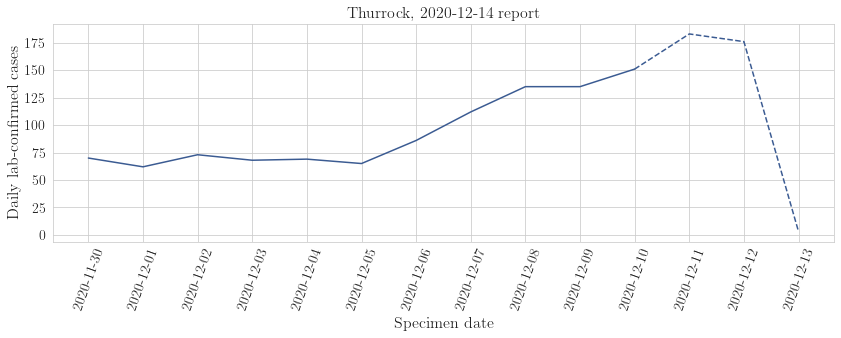

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(14,4))

plt.plot(specimen_dates[:-3], ys_sequence[:-3], "xkcd:denim blue")
plt.plot(specimen_dates[-4:], ys_sequence[-4:], color="xkcd:denim blue", linestyle="--")

plt.title(f"{ltla}, {report_dt} report", fontsize=16)
plt.ylabel('Daily lab-confirmed cases', fontsize=16)
plt.xlabel('Specimen date', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=70)

plt.show()

## Reporting lag priors ($\theta_j$)

In [6]:
from data_processing.data import get_data, moment_match_theta_priors

A core assumption of the model is that the reporting lag is consistent and predictable. 

We load two weeks of prior reports to learn the most recent reporting behaviour from the data. Specifically we look at the proportion of the final count that is reported (`prop_reported`) at each `lag` (where `lag` is the difference in days between `Specimen date` and `Report date`). We denote the reporting rate parameters $\theta_j$.

In [7]:
last_report_dt = pd.to_datetime(report_dt)
report_dates = pd.date_range(start=last_report_dt - timedelta(14), end=last_report_dt)

historical_df = get_data(ltla, report_dates=report_dates)

In [8]:
historical_df[['Specimen date', 'Report date', 'Daily lab-confirmed cases', 'prop_reported', 'lag']
             ].query("(`Specimen date` == '2020-12-03' | `Specimen date` == '2020-12-04') & lag <= 5"
                    ).sort_values(['Specimen date','Report date'])

,Specimen date,Report date,Daily lab-confirmed cases,prop_reported,lag
54,2020-12-03,2020-12-04,2,0.029412,1
55,2020-12-03,2020-12-05,49,0.720588,2
56,2020-12-03,2020-12-06,64,0.941176,3
57,2020-12-03,2020-12-07,66,0.970588,4
58,2020-12-03,2020-12-08,66,0.970588,5
65,2020-12-04,2020-12-05,2,0.028986,1
66,2020-12-04,2020-12-06,65,0.942029,2
67,2020-12-04,2020-12-07,67,0.971014,3
68,2020-12-04,2020-12-08,70,1.000000,4
69,2020-12-04,2020-12-09,70,1.000000,5


For each `lag` $j$ we moment match to the data (`prop_reported`) to get the $\alpha_j$ and $\beta_j$ shape parameters of a Beta prior on $\theta_j$.

In [9]:
alphas, betas = moment_match_theta_priors(historical_df, n_lags=len(ys_sequence))

Below we plot the reporting data and the corresponding Beta prior for the first 5 lags.

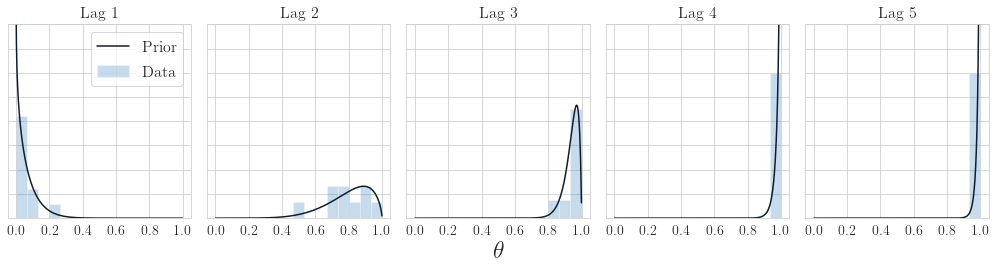

In [10]:
fig, ax = plt.subplots(1, 5, figsize=(14, 4))
x = np.linspace(0, 1, 1002)[1:-1]

for i in range(1, 6):
    curr_ax = ax[i-1]
    
    empirical = historical_df[historical_df['lag']==i][:-4]
    curr_ax.hist(empirical['prop_reported'], range=(0,1), bins=15, label='Data', alpha=0.25, density=True)

    dist = beta(alphas[-i], betas[-i])
    curr_ax.plot(x, dist.pdf(x), label='Prior', color="#0e1c2e")

    curr_ax.set_ylim(0,20)

    if i == 0:
        curr_ax.set_ylabel(f"{l}", fontsize=16)
    curr_ax.set_yticklabels([])

    curr_ax.set_title(f"Lag {i}", fontsize=16)

    if i==3:
        curr_ax.set_xlabel('$\theta$', fontsize=24)

    plt.setp(curr_ax.get_xticklabels(), fontsize=14)
    plt.setp(curr_ax.get_yticklabels(), fontsize=14)
    
ax[0].legend(fontsize=16)
plt.suptitle(f"", fontsize=16)
plt.tight_layout() 

## Model

In [12]:
from models.inference import Nowcaster

To instantiate the Nowcaster model class we have to specify (i) the reporting lag priors learned in the previous step and (ii) the scale ($\sigma$) of the temporal smoothing applied by the random walk prior. In practice we would run the model with a number of different scales and choose the model that maximises the model evidence.

In [13]:
model = Nowcaster(
            random_walk_scale=4,
            prior_theta_shape_a = alphas,
            prior_theta_shape_b = betas
)

Once the model is instantiated, we pass the reported counts and dates to the `model.fit()` method. Including the dates is required for the model to account for weekend effects.

In [14]:
model.fit(
    observations=ys_sequence,
    dates=specimen_dates
)

## Model outputs

The Nowcaster class comes with methods to access and plot the model outputs once fit to data.

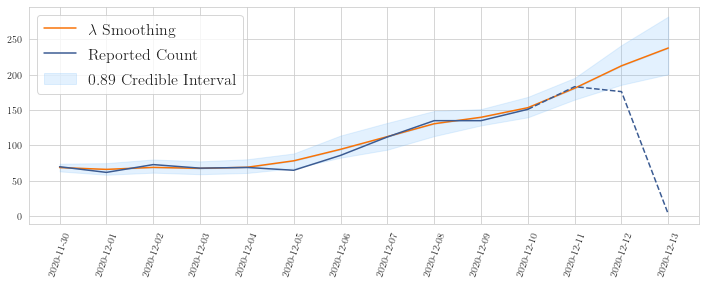

In [15]:
model.plot_lambda_smoothing()

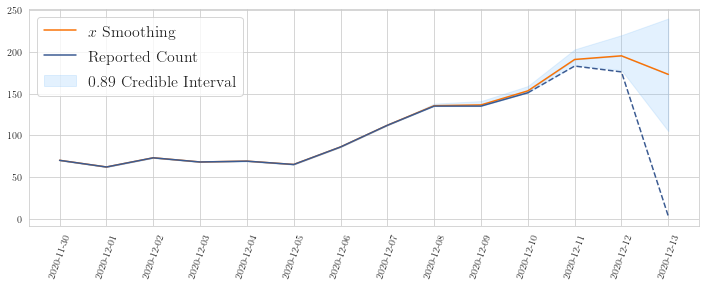

In [16]:
model.plot_x_smoothing()

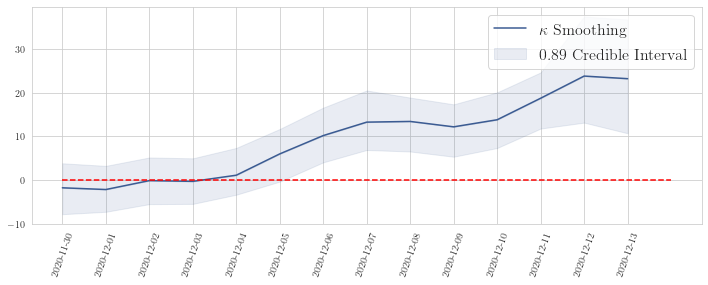

In [19]:
model.plot_drift_smoothing()

The samples plotted above can also be accessed directly as properties of the Nowcaster class:

- `model.lambda_smoothing_samples`
- `model.x_smoothing_samples`
- `model.kappa_smoothing_samples`

In [20]:
[x.mean() for x in model.x_smoothing_samples]

[70.002,
 62.018,
 73.0,
 68.011,
 69.0,
 65.015,
 86.0,
 112.011,
 135.505,
 136.42,
 153.269,
 190.919,
 195.289,
 173.034]

The Nowcaster class also returns the model evidence.

In [21]:
sum(model.log_evidence)

33.26746356820296